In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import yaml
import glob
import torch
import numpy as np
from torch import nn
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset

import logging
from importlib import reload  # Not needed in Python 2
reload(logging)

torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )



from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs


In [1]:
import sys
sys.path.append( '/anaconda/envs/py37_pytorch/lib/python3.7')
sys.path.append('/anaconda/envs/py37_pytorch/lib/python3.7/site-packages')

In [3]:
with open('config/cfg.yaml','r') as f:
    cfg = yaml.load(f)

cfg = {**cfg['step1'],**cfg['share_cfg']}
T = cfg['T']
pollution = cfg['pollution']
batch_size = cfg['batch_size']

print('train data is loading ')
Data = AS_Data(cfg['data_path'],left = cfg['train']['left'],right = cfg['train']['right'],window = T,pollution = pollution)
trainloader = DataLoader(Data,batch_size=batch_size,shuffle=True)
print(len(Data))

print('test data is loading ')
test_Data = AS_Data(cfg['data_path'],left = cfg['test']['left'],right = cfg['test']['right'],window = T,pollution = pollution)
testloader = DataLoader(test_Data,batch_size=batch_size,shuffle=True)
print(len(test_Data))

/home/v-zeyyan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'train': {'left': 0, 'right': 0.75}, 'test': {'left': 0.75, 'right': 1}, 'batch_size': 2, 'data_path': {'EM': '/AS_data/zeyuan_folder/concat_data/*07_182_232.npy', 'label': '/AS_data/Conc_npy/TOTAL_2015_*', 'grid': '/AS_data/Grid_npy/grid_27_182_232.npy', 'METCRO2D': '/AS_data/METCRO2D_npy/METCRO2D_2015_*', 'METCRO3D': '', 'METCRO3D_5height': '', 'obs_label': '/AS_data/obs_npy/obs2015_*'}, 'T': 24, 'pollution': ['PM25', 'O3', 'NO2', 'SO2'], 'emission_dim': 7, 'meteorological_dim': 34, 'grid_dim': 27, 'name': 'model_save/resnet_LSTM_ALL_7emssion_PM25_O3_NO2_SO2_best_epoch.t'}
train data is loading 
/AS_data/Conc_npy/TOTAL_2015_01_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_04_NO2_SO2_O3_PM25_PM10_CO__720_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_07_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_10_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
(558, 4, 182, 232)
/AS_data/zeyuan_folder/

In [4]:
from model.res_model_LSTM import res8
from model.unet_model_LSTM import UNet

test_model = res8(cfg['meteorological_dim']+cfg['emission_dim'],cfg['grid_dim'],T=T,pre_dim = len(pollution)) #+5*16
name = cfg['name']
# test_model = UNet(cfg['meteorological_dim']+cfg['emission_dim'],cfg['grid_dim'],T=T,bilinear=False,pre_dim = len(pollution)) #+80
# name = cfg['name']
# test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

test_model.to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(test_model.parameters(),lr=1e-3)


In [5]:
def score(model,loader,criterion= nn.L1Loss(),percent = False):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            input,grid,yt_1,label = i
            input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
            y_pred = model(input,grid,yt_1)
            
            cur_loss = []
            for j in range(label.shape[1]):
                if percent:
                    for esp in [0.1,1,4,8,12,16]:
                        loss = torch.mean(torch.abs(y_pred[:,j]-label[:,j])/(label[:,j]+esp))
                        cur_loss.append(loss.cpu().data)
                else:
                    loss = criterion(y_pred[:,j],label[:,j])
                    cur_loss.append(loss.cpu().data)

            ls.append(cur_loss)
            
    return np.mean(np.array(ls),axis = 0)

In [6]:
best_score = 1000
early_stop = 15
early_cnt = 0
for epoch in range(21):
    logging.info('-----------{}-----------'.format(epoch))
    print('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.train()
    for idx,i in enumerate(trainloader):
#         print(idx)
        input,grid,yt_1,label = i
        input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
        y_pred = test_model(input,grid,yt_1)
        
        assert y_pred.shape == label.shape
        
        optimizer.zero_grad()
        
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        if len(ls)%40==0:
            logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
            print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,testloader,criterion = nn.L1Loss()) 
    logging.info('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))
    print('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))
    
#     if epoch%5 == 0:
#         torch.save(test_model.cpu().state_dict(),'model_save/{}_{}_epoch.t'.format(name,epoch))
#         test_model.to(device)
    if np.sum(test_score_L1)<best_score:
        early_cnt = 0
        best_score = np.sum(test_score_L1)
        torch.save(test_model.cpu().state_dict(),name)
        test_model.to(device)
    else:
        early_cnt += 1
        if early_cnt>=early_stop:
            break

-----------0-----------
epoch 0 cur loss 9.180508613586426
epoch 0 cur loss 6.638710021972656
epoch 0 cur loss 5.611952781677246
epoch 0 cur loss 5.08121395111084
epoch 0 cur loss 4.692701816558838
epoch 0 cur loss 4.422420978546143
epoch 0 cur loss 4.231252670288086
epoch 0 cur loss 4.055829048156738
epoch 0 cur loss 3.9272053241729736
epoch 0 cur loss 3.829693078994751
epoch 0 cur loss 3.733034372329712
epoch 0 cur loss 3.6553428173065186
epoch 0 cur loss 3.5820438861846924
epoch 0 cur loss 3.5208089351654053
epoch 0 cur loss 3.4672276973724365
epoch 0 cur loss 3.4230353832244873
epoch 0 cur loss 3.3842341899871826
epoch 0 cur loss 3.3454580307006836
epoch 0 cur loss 3.304335832595825
epoch 0 cur loss 3.2683966159820557
epoch 0 cur loss 3.244678497314453
epoch 0 cur loss 3.2164065837860107
epoch 0 cur loss 3.1914944648742676
epoch 0 cur loss 3.168255567550659
epoch 0 cur loss 3.14125919342041
epoch 0 cur loss 3.117840051651001
epoch 0 cur loss 3.1055243015289307
-------------cur test

epoch 7 cur loss 1.9185776710510254
epoch 7 cur loss 1.9180094003677368
epoch 7 cur loss 1.9181753396987915
epoch 7 cur loss 1.9147545099258423
epoch 7 cur loss 1.9129050970077515
-------------cur test loss L1:  3.3961213,4.039499,0.57711345,0.4210742
-----------8-----------
epoch 8 cur loss 1.877274751663208
epoch 8 cur loss 1.9001632928848267
epoch 8 cur loss 1.8996765613555908
epoch 8 cur loss 1.887477159500122
epoch 8 cur loss 1.8895913362503052
epoch 8 cur loss 1.8905341625213623
epoch 8 cur loss 1.8755937814712524
epoch 8 cur loss 1.8697149753570557
epoch 8 cur loss 1.8670340776443481
epoch 8 cur loss 1.8657571077346802
epoch 8 cur loss 1.8680284023284912
epoch 8 cur loss 1.8729749917984009
epoch 8 cur loss 1.8778971433639526
epoch 8 cur loss 1.8746525049209595
epoch 8 cur loss 1.8765498399734497
epoch 8 cur loss 1.878154993057251
epoch 8 cur loss 1.8755990266799927
epoch 8 cur loss 1.8768378496170044
epoch 8 cur loss 1.8774155378341675
epoch 8 cur loss 1.878409743309021
epoch 8 

epoch 15 cur loss 1.7330844402313232
epoch 15 cur loss 1.7277370691299438
epoch 15 cur loss 1.7296122312545776
epoch 15 cur loss 1.7272288799285889
epoch 15 cur loss 1.7245742082595825
epoch 15 cur loss 1.7273235321044922
epoch 15 cur loss 1.7242281436920166
epoch 15 cur loss 1.721824288368225
epoch 15 cur loss 1.7239753007888794
epoch 15 cur loss 1.7255511283874512
epoch 15 cur loss 1.7271555662155151
epoch 15 cur loss 1.7301439046859741
epoch 15 cur loss 1.7299326658248901
epoch 15 cur loss 1.7306617498397827
epoch 15 cur loss 1.73130202293396
epoch 15 cur loss 1.7292096614837646
epoch 15 cur loss 1.7283064126968384
-------------cur test loss L1:  3.2024093,3.7647543,0.5226204,0.35378075
-----------16-----------
epoch 16 cur loss 1.7394599914550781
epoch 16 cur loss 1.7445545196533203
epoch 16 cur loss 1.7568472623825073
epoch 16 cur loss 1.7469794750213623
epoch 16 cur loss 1.7462549209594727
epoch 16 cur loss 1.7393858432769775
epoch 16 cur loss 1.7278269529342651
epoch 16 cur loss

In [5]:
test_model.load_state_dict(torch.load(name))

# test_model = res8(51+34+16,27,[3],T=48)

test_model = test_model.to(device)

In [6]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',base=80):
    image = im.copy()
    image[:5,:5] = base
    plt.title(title)
    plt.imshow(image[::-1],cmap=plt.cm.hot_r)
    plt.colorbar()
    

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.37390935e+00 1.27203679e+00 1.26914239e+00 ... 9.13449764e-01
    5.27091742e-01 9.75186288e-01]
   [1.51257253e+00 1.37020445e+00 1.33286023e+00 ... 9.39782083e-01
    8.97941172e-01 4.82627988e-01]
   [1.57041240e+00 1.44015741e+00 1.37890196e+00 ... 1.06596172e+00
    1.09364259e+00 5.01998186e-01]
   ...
   [1.21238518e+00 1.03978598e+00 1.02417886e+00 ... 9.61508632e-01
    1.02619386e+00 1.17672622e+00]
   [1.15118968e+00 1.06329525e+00 1.06320012e+00 ... 8.07203591e-01
    9.79063094e-01 1.08604491e+00]
   [1.03678429e+00 1.02162111e+00 1.02112472e+00 ... 8.03114653e-01
    1.01335752e+00 1.09887600e+00]]

  [[3.28229790e+01 3.16143417e+01 3.15110302e+01 ... 3.15840130e+01
    3.30190697e+01 3.43396225e+01]
   [3.53168068e+01 3.36941452e+01 3.29284363e+01 ... 3.10180244e+01
    3.22585983e+01 3.57643776e+01]
   [3.63484993e+01 3.48187943e+01 3.34904137e+01 ... 3.01611938e+01
    3.15595341e+01 3.55242653e+01]
   ...
   [2.83562431e+01 2.74

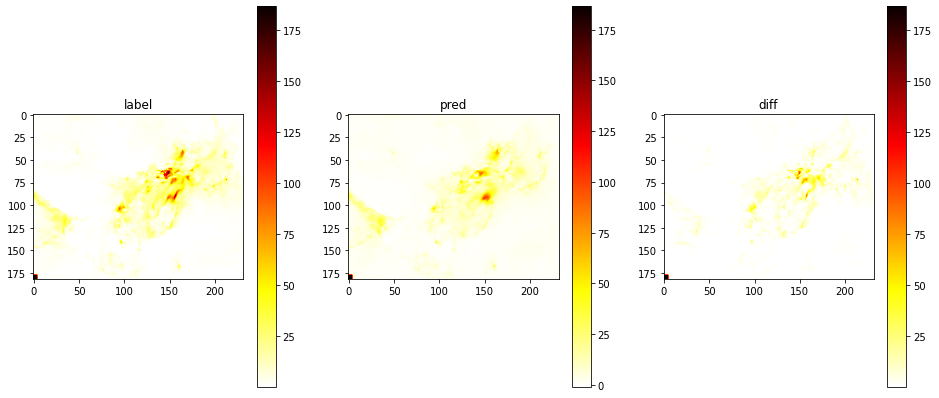

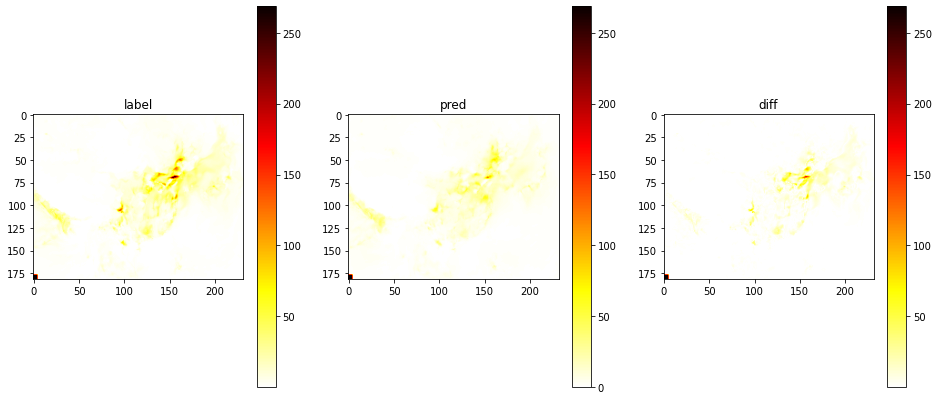

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.35373831e+00 1.24053311e+00 1.21381021e+00 ... 4.50458139e-01
    4.15571719e-01 1.02564025e+00]
   [1.45727777e+00 1.32940125e+00 1.26735449e+00 ... 5.60433984e-01
    5.28546691e-01 8.99088681e-01]
   [1.49067497e+00 1.38629067e+00 1.32670510e+00 ... 6.47273719e-01
    9.25007522e-01 1.08915126e+00]
   ...
   [1.45450830e+00 1.13500559e+00 1.02883005e+00 ... 1.24035347e+00
    1.20190811e+00 1.18753254e+00]
   [1.27760720e+00 1.09234786e+00 1.05544806e+00 ... 1.23190463e+00
    1.12727737e+00 9.52181578e-01]
   [1.10394645e+00 1.03312469e+00 1.02599144e+00 ... 1.19539738e+00
    1.17908084e+00 1.11869180e+00]]

  [[3.43451958e+01 3.32235260e+01 3.28016090e+01 ... 3.10376263e+01
    3.33166351e+01 3.27707520e+01]
   [3.72427406e+01 3.61320496e+01 3.45416374e+01 ... 3.06281490e+01
    3.22692146e+01 3.39519768e+01]
   [3.84109688e+01 3.82354622e+01 3.67441978e+01 ... 3.05282001e+01
    3.10177345e+01 3.15377827e+01]
   ...
   [2.85557423e+01 2.90

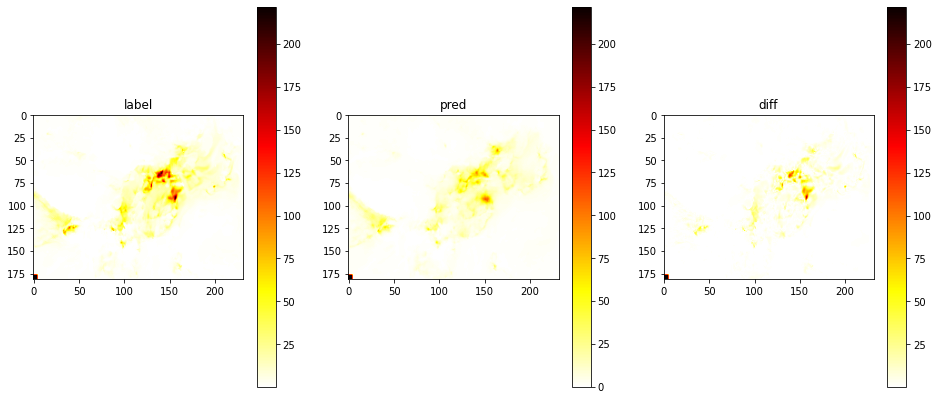

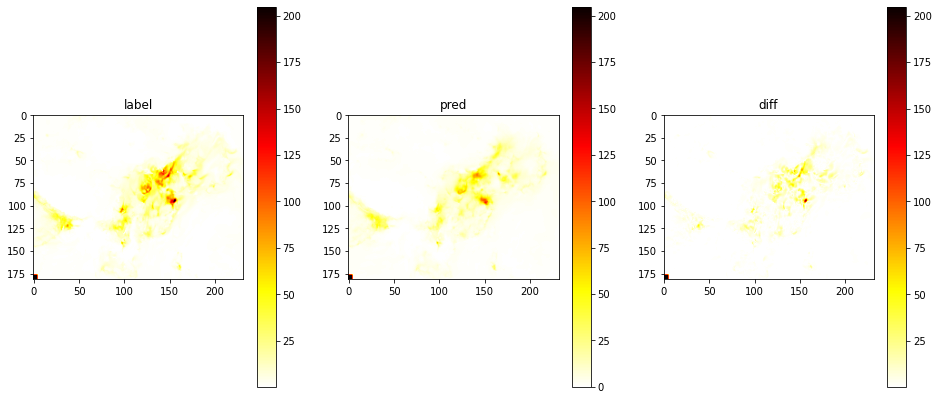

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.3096339e+00 1.2221788e+00 1.2174907e+00 ... 1.0147691e+00
    9.3677562e-01 9.2088628e-01]
   [1.4055011e+00 1.2817667e+00 1.2445837e+00 ... 8.5859782e-01
    7.6192439e-01 7.5365555e-01]
   [1.4583247e+00 1.3817396e+00 1.3309460e+00 ... 8.0902094e-01
    7.6112765e-01 7.0700848e-01]
   ...
   [8.6734885e-01 8.6368096e-01 9.1779745e-01 ... 1.2103124e-01
    1.3520192e-01 7.3353523e-01]
   [8.5798842e-01 8.4051353e-01 8.5398990e-01 ... 2.8533918e-01
    4.9209425e-01 1.1442313e+00]
   [8.8144791e-01 8.2240546e-01 8.1548411e-01 ... 2.0041376e-01
    5.4442322e-01 1.1877989e+00]]

  [[3.3030674e+01 3.1909986e+01 3.1916536e+01 ... 3.1824574e+01
    3.2403366e+01 3.2846577e+01]
   [3.5372028e+01 3.4007019e+01 3.3247845e+01 ... 3.1875008e+01
    3.2651852e+01 3.2924347e+01]
   [3.7630196e+01 3.6554928e+01 3.5585316e+01 ... 2.7824879e+01
    2.7672604e+01 2.7889011e+01]
   ...
   [3.7376472e+01 3.7646397e+01 3.7849575e+01 ... 2.8757385e+01
    2.9137568

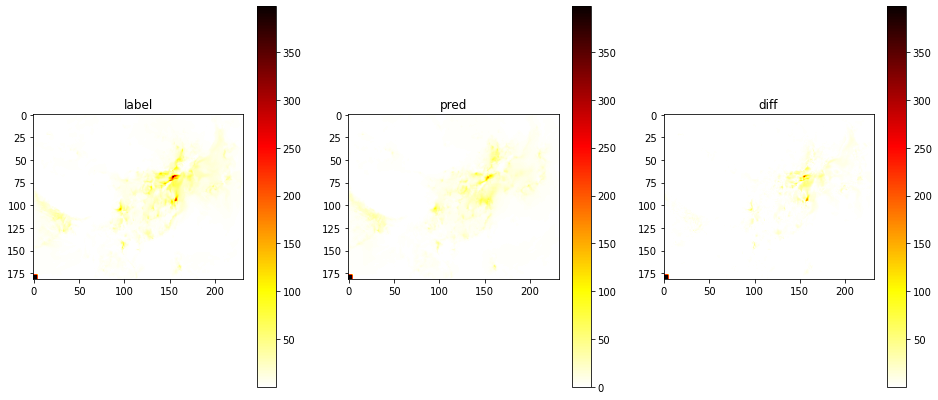

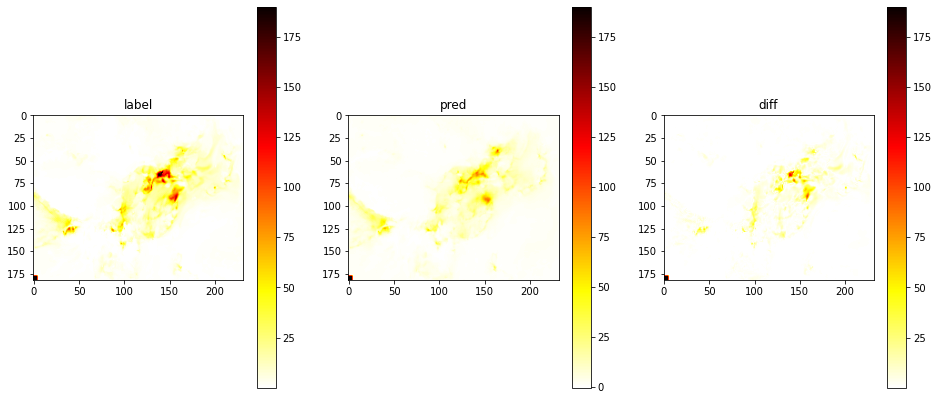

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.52286816e+00 1.40864575e+00 1.31076014e+00 ... 6.00789666e-01
    8.66260767e-01 6.06119752e-01]
   [1.56212187e+00 1.53319037e+00 1.54492390e+00 ... 2.99598694e-01
    6.67488039e-01 8.04360390e-01]
   [1.59506297e+00 1.54132879e+00 1.56205618e+00 ... 3.77872735e-01
    3.11431199e-01 7.40557194e-01]
   ...
   [1.26462603e+00 1.14154327e+00 1.14171720e+00 ... 1.29215026e+00
    1.28287697e+00 1.20580590e+00]
   [1.28655183e+00 1.14152670e+00 1.09972823e+00 ... 1.29267871e+00
    1.23979831e+00 1.20777965e+00]
   [1.22839630e+00 9.65647280e-01 9.17012572e-01 ... 1.26866388e+00
    1.22902524e+00 1.20757151e+00]]

  [[3.66701851e+01 3.53742447e+01 3.33099785e+01 ... 2.63768635e+01
    2.70760803e+01 3.62559433e+01]
   [3.87103271e+01 3.99442482e+01 3.89948120e+01 ... 3.42233849e+01
    3.02406826e+01 3.09884167e+01]
   [3.82667656e+01 4.07455368e+01 4.09587593e+01 ... 3.45684395e+01
    3.72741051e+01 3.43346214e+01]
   ...
   [4.30826607e+01 4.53

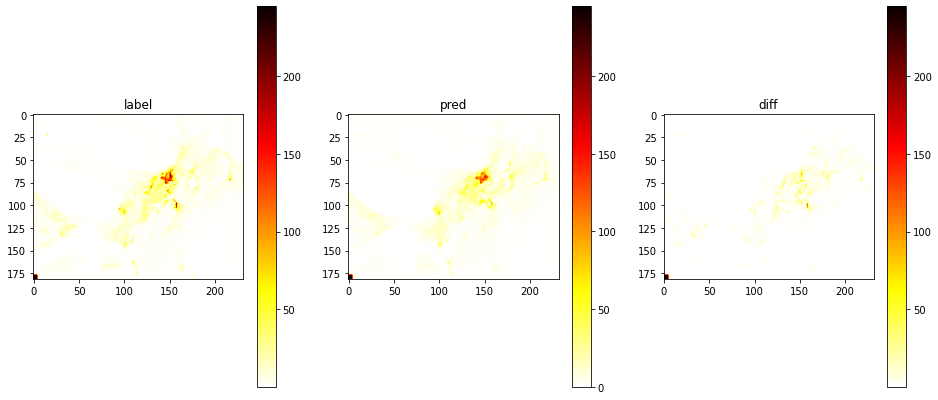

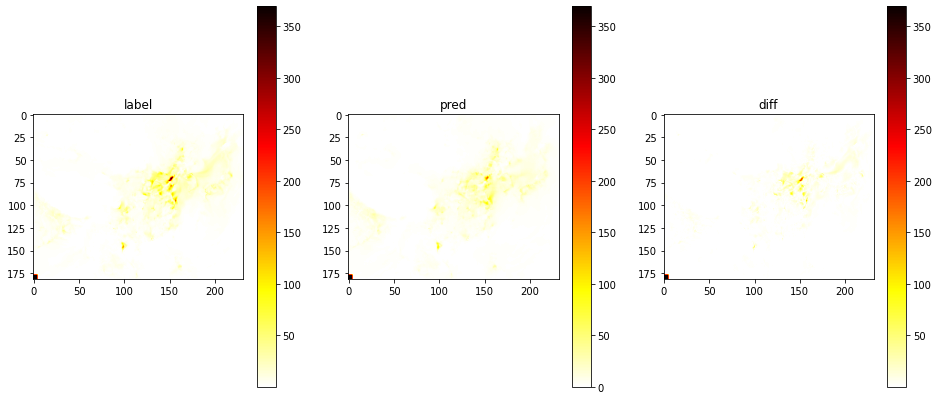

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.47769451e+00 1.34759140e+00 1.26991296e+00 ... 1.09026945e+00
    1.06574261e+00 1.06643450e+00]
   [1.60935640e+00 1.56893659e+00 1.47806954e+00 ... 9.16182399e-01
    8.23094070e-01 8.23708355e-01]
   [1.60373008e+00 1.58380508e+00 1.60374761e+00 ... 7.78825581e-01
    7.18360484e-01 6.76717997e-01]
   ...
   [7.77011871e-01 7.80082285e-01 7.81198919e-01 ... 9.65296328e-01
    1.00212359e+00 1.14732301e+00]
   [7.84853101e-01 7.82224178e-01 7.81435370e-01 ... 7.60617435e-01
    9.74932075e-01 1.12918174e+00]
   [8.02574754e-01 8.05801332e-01 8.03723574e-01 ... 9.30547297e-01
    9.63357031e-01 1.15824497e+00]]

  [[3.55555077e+01 3.40177879e+01 3.24983864e+01 ... 3.14872856e+01
    3.17276745e+01 3.20629463e+01]
   [3.74124336e+01 3.75256081e+01 3.61532135e+01 ... 2.92718410e+01
    2.95903664e+01 2.97557602e+01]
   [3.72007713e+01 3.87462540e+01 3.83212433e+01 ... 2.59136696e+01
    2.63902225e+01 2.68620834e+01]
   ...
   [3.78253059e+01 3.78

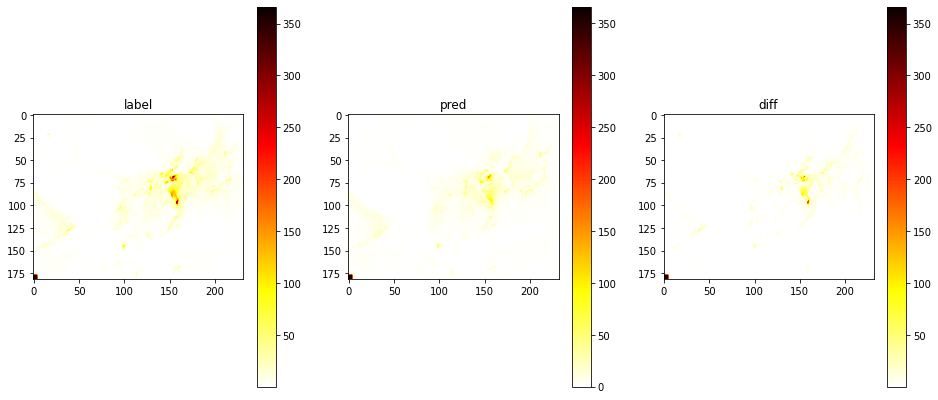

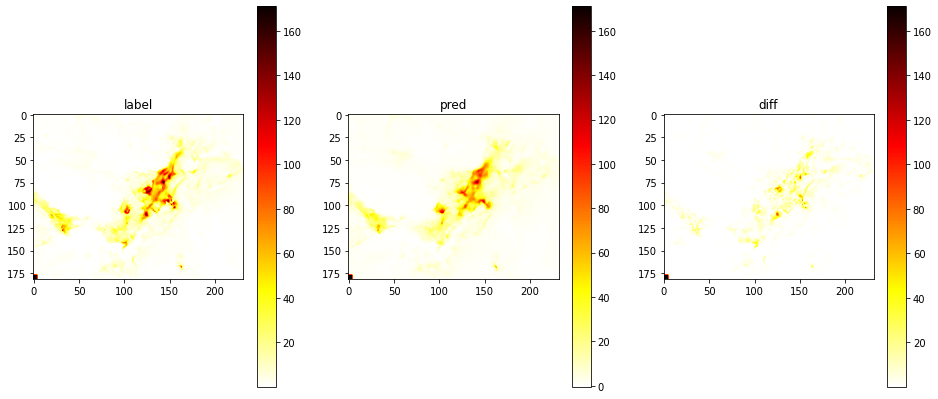

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.38070869e+00 1.26425445e+00 1.25750804e+00 ... 9.74129438e-01
    9.04821634e-01 8.83559465e-01]
   [1.50204217e+00 1.34439397e+00 1.30183089e+00 ... 8.01158369e-01
    7.29387939e-01 6.85129523e-01]
   [1.52922142e+00 1.39954054e+00 1.32289004e+00 ... 7.35794365e-01
    7.08524644e-01 6.59112513e-01]
   ...
   [9.14820313e-01 9.62539375e-01 1.03621614e+00 ... 1.53023973e-01
    3.36058974e-01 8.86826873e-01]
   [8.89275789e-01 9.24607575e-01 9.58809495e-01 ... 2.99882919e-01
    8.67810488e-01 1.12747526e+00]
   [9.57253277e-01 9.05516982e-01 8.90643001e-01 ... 3.91898155e-01
    9.15846407e-01 1.17883229e+00]]

  [[3.31475601e+01 3.17688961e+01 3.16371403e+01 ... 3.21110878e+01
    3.28284569e+01 3.42681694e+01]
   [3.53069458e+01 3.36439438e+01 3.28272934e+01 ... 3.26965637e+01
    3.39123077e+01 3.42425346e+01]
   [3.68824348e+01 3.53676453e+01 3.35160255e+01 ... 2.84811172e+01
    2.84400349e+01 2.85430679e+01]
   ...
   [3.33308067e+01 3.44

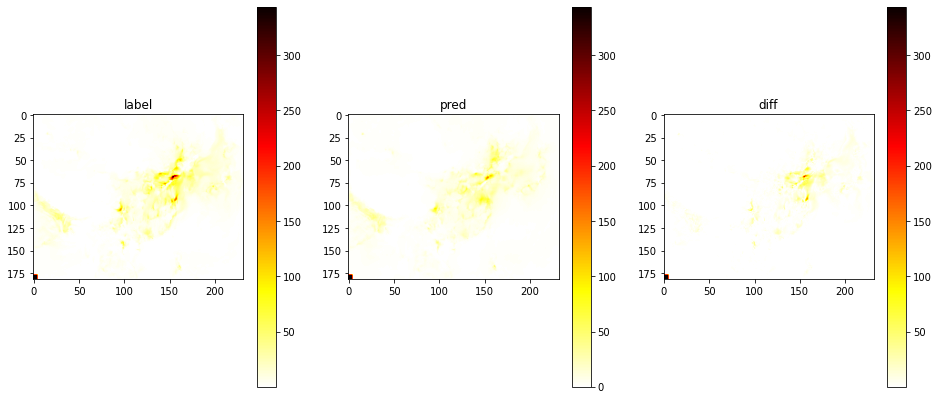

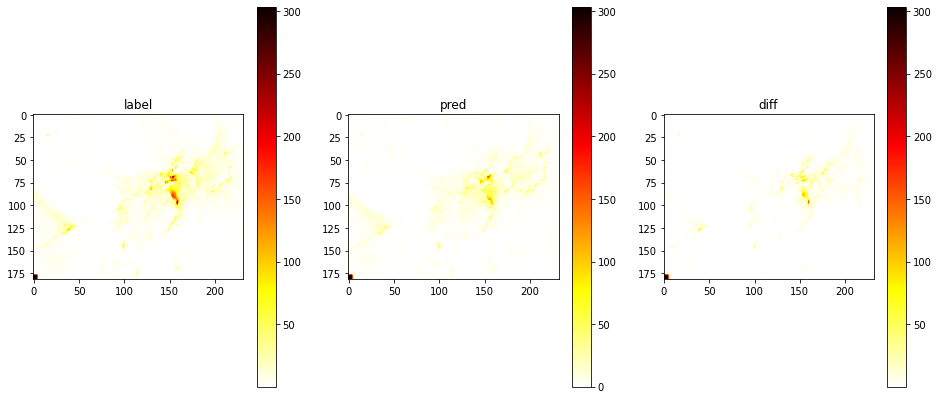

(2, 4, 182, 232)
(2, 4, 182, 232)
[[[[1.46921933e+00 1.31196046e+00 1.29319894e+00 ... 1.04003096e+00
    9.47658181e-01 8.72894049e-01]
   [1.60425127e+00 1.52706528e+00 1.43353093e+00 ... 8.46062303e-01
    7.81388819e-01 7.04109251e-01]
   [1.63007140e+00 1.59507608e+00 1.57627165e+00 ... 6.92925751e-01
    6.06977701e-01 5.34390628e-01]
   ...
   [1.08790684e+00 1.27230656e+00 1.32167614e+00 ... 4.89423215e-01
    6.94872141e-01 1.13808739e+00]
   [1.02570128e+00 1.14308178e+00 1.22928393e+00 ... 5.21396399e-01
    1.02970052e+00 1.16401708e+00]
   [1.01026607e+00 1.04474056e+00 1.13595021e+00 ... 7.64480114e-01
    1.13378930e+00 1.17592680e+00]]

  [[3.42342682e+01 3.28266678e+01 3.20221634e+01 ... 3.21972885e+01
    3.31394310e+01 3.55051117e+01]
   [3.67698708e+01 3.61270180e+01 3.38276329e+01 ... 3.32497864e+01
    3.50085869e+01 3.59181366e+01]
   [3.72938843e+01 3.76716080e+01 3.63553276e+01 ... 3.17439442e+01
    3.31538849e+01 3.28618698e+01]
   ...
   [2.29842396e+01 2.21

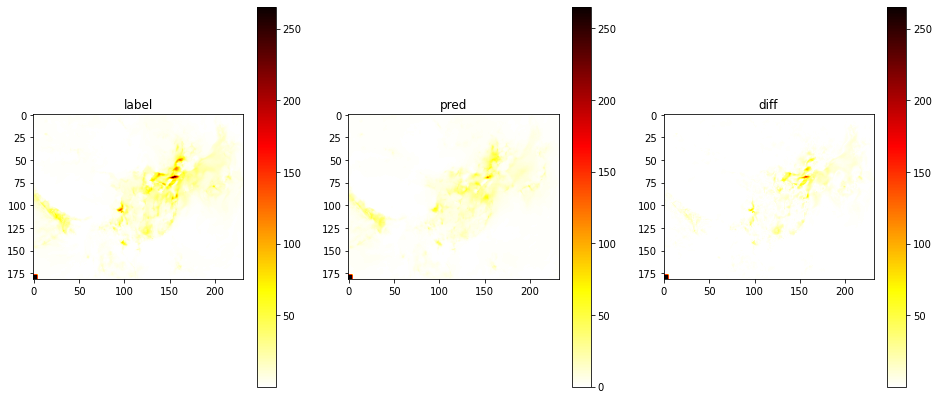

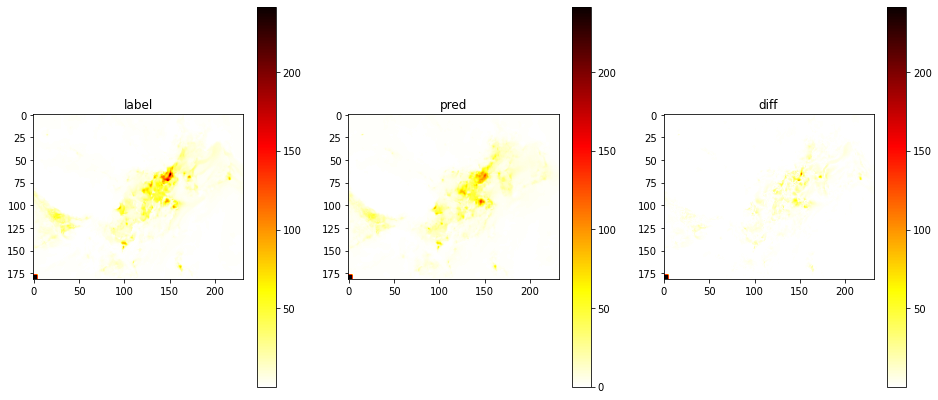

In [8]:
plt.rcParams['figure.figsize'] = (16,7.0)

test_model.eval()
air_idx = 0 #pm25

for idx,i in enumerate(testloader):
    with torch.no_grad():
        input,grid,yt_1,label = i
        input = torch.squeeze(input,1)
        input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
        y_pred = test_model(input,grid,yt_1)
        
        label = label.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        print(label.shape)
        print(y_pred.shape)
        print(label)
        for b_idx in range(len(label)):
            
            plt.subplot(1,3,1)
            image1 = label[b_idx,air_idx]
            max_label = np.max(image1)
            image_show(image1,'label',base=max_label)
            
            plt.subplot(1,3,2)
            image2 = y_pred[b_idx,air_idx]
            image_show(image2,'pred',base=max_label)
            
            plt.subplot(1,3,3)
            image3 = np.abs(image2-image1)
            image_show(image3,'diff',base=max_label)
            plt.show()
        if idx>5:break
